In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings 
warnings.filterwarnings("ignore")
import os
import nltk
import re
import json
from tqdm import tqdm
import zipfile
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
train_path = 'train.json'
test_path = 'test.json'

In [3]:
with open(train_path, encoding='utf-8') as f:
    train = json.load(f)

with open(test_path, encoding='utf-8') as f:
    test = json.load(f)

df = pd.DataFrame(train)
df_test = pd.DataFrame(test)
test_ids = df_test['id']

# Exploratory Data Analysis (EDA)

    Read Dataset
    Perform EDA

In [4]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
df.tail()

,id,cuisine,ingredients
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."
39773,2362,mexican,"[green chile, jalapeno chilies, onions, ground..."


In [6]:
df.shape

(39774, 3)

In [7]:
df.columns

Index(['id', 'cuisine', 'ingredients'], dtype='object')

In [8]:
df['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [9]:
#how many examples we have of each cuisine
df["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

Now we are checking for null values in train dataset. We can see we have zero null values.

In [10]:
df.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

We are now checking for null values in test dataset. We can see we have zero null values.

In [11]:
df_test.isnull().sum()

id             0
ingredients    0
dtype: int64

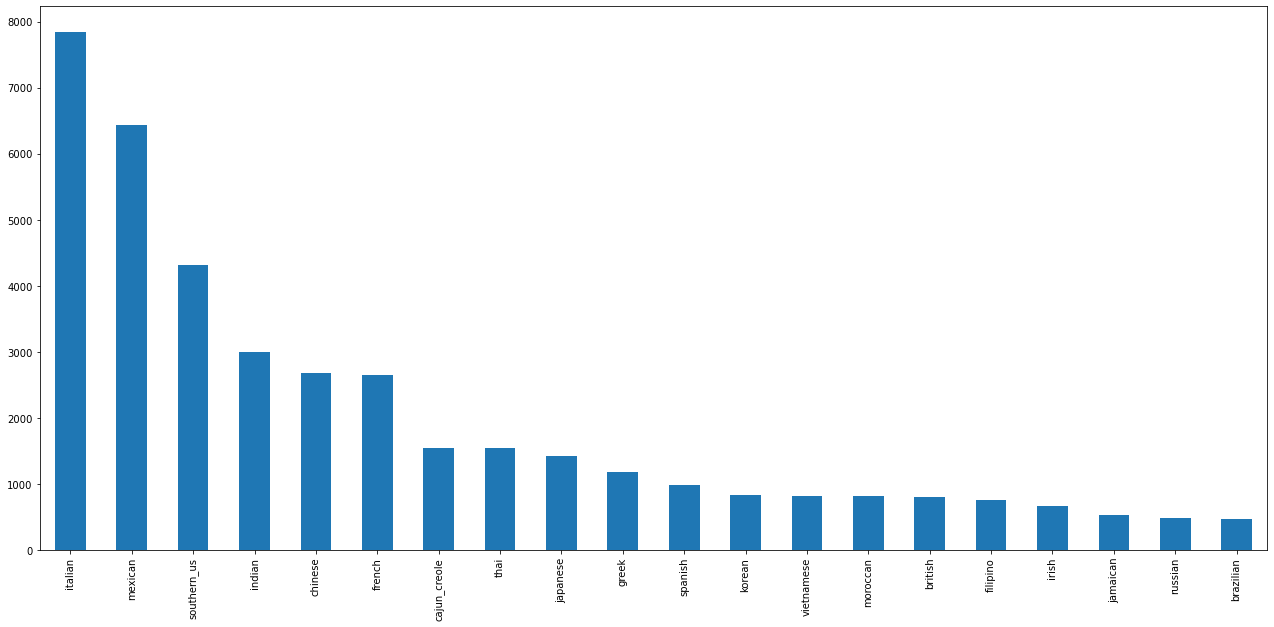

In [12]:
fig, ax = plt.subplots(figsize=(22,10))
df['cuisine'].value_counts().sort_values(ascending=False).head(30).plot.bar(ax = ax)

In [13]:
#Takes a lot of time to process, that's why those lines are comments. If you want to run you delete the '#'.
#fig, ax = plt.subplots(figsize=(22,10))
#df['ingredients'].value_counts().sort_values(ascending=False).head(30).plot.bar(ax = ax)

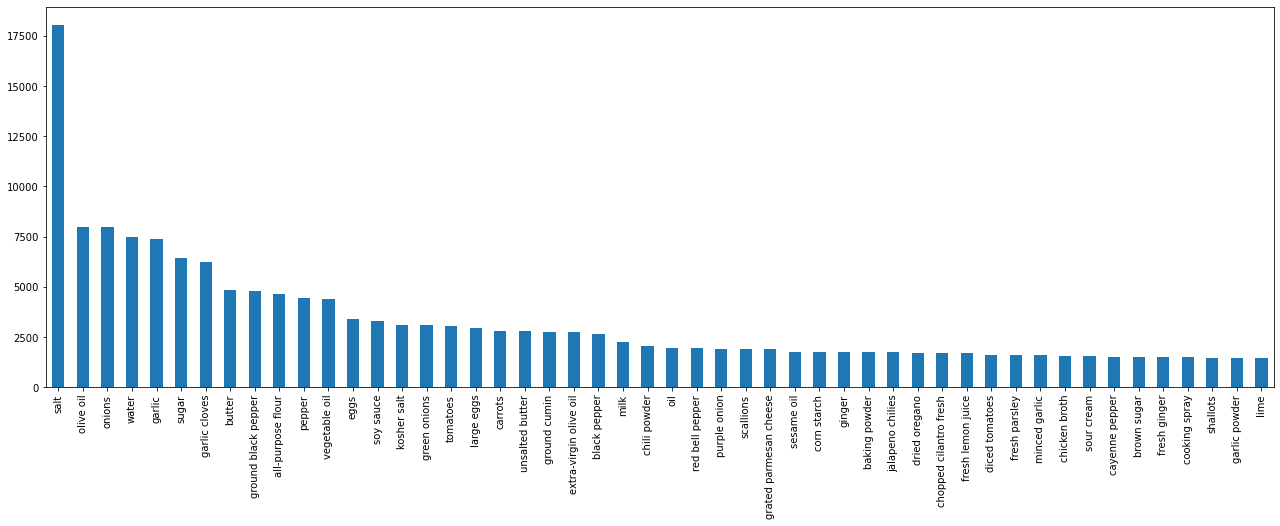

In [14]:
fig, ax = plt.subplots(figsize=(22,7))
ingredients = []
for x in df['ingredients']:
    for y in x:
        ingredients.append(y)
        
ingredients = pd.Series(ingredients)
ingredients.value_counts().sort_values(ascending=False).head(50).plot.bar(ax = ax)

# Preprocessing 

We are going to apply string preprocessing 

In [15]:
def lemmatization(string):
    string = [" ".join([WordNetLemmatizer().lemmatize(q) for q in p.split()]) for p in string]
    return string

In [16]:
def clean_data(string):
    x = string
    # Remove punctuation
    x = list(map(lambda x: re.sub('[,.₺…$%€!?;:\"\']', ' ', x), x))
    
    #Remove unnecessary numbers
    x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))
    
    # Replace \n with ' '
    x = list(map(lambda x: re.sub(r'\n', ' ', x), x))

    # Remove extra space
    x = list(map(lambda x: re.sub(r'  ', ' ', x), x))
    
    # Remove adjectives that are not serving to our purpose
    x = list(map(lambda x: re.sub(r'\(.*oz.\)|crumbles|sliced|minced|crushed|chopped|ground','', x), x))
    
    # Convert the titles to lowercase
    x = list(map(lambda x: x.lower(), x))
    
    x = " ".join(x) 
    
    return x 

In [17]:
def applying(df):
    df = df.drop('id',axis=1)
    df['ingredients'] = df['ingredients'].apply(lemmatization)
    df['ingredients'] = df['ingredients'].apply(clean_data)
    return df

In [18]:
#if nltk is not available in your enviroment, pls run the code below:
#nltk.download('wordnet')
df = applying(df)
df.head()

,cuisine,ingredients
0,greek,romaine lettuce black olive grape tomato garli...
1,southern_us,plain flour pepper salt tomato black pepper ...
2,filipino,egg pepper salt mayonaise cooking oil green ch...
3,indian,water vegetable oil wheat salt
4,indian,black pepper shallot cornflour cayenne pepper ...


In [19]:
#Applying the same process to our test data. 
df_test = applying(df_test)
df_test.head()
#By doing so, our preprocessing is done. 

,ingredients
0,baking powder egg all purpose flour raisin mil...
1,sugar egg yolk corn starch cream of tartar ban...
2,sausage link fennel bulb frond olive oil cuban...
3,meat cut file powder smoked sausage okra shrim...
4,black pepper salt sausage casing leek parmigi...


In [20]:
train = df['ingredients']
test = df_test['ingredients']
target = df['cuisine']

In [21]:
df['ingredients'][0]

'romaine lettuce black olive grape tomato garlic pepper purple onion seasoning garbanzo bean feta cheese '

In [22]:
df_test['ingredients']

0       baking powder egg all purpose flour raisin mil...
1       sugar egg yolk corn starch cream of tartar ban...
2       sausage link fennel bulb frond olive oil cuban...
3       meat cut file powder smoked sausage okra shrim...
4        black pepper salt sausage casing leek parmigi...
                              ...                        
9939    large egg yolk fresh lemon juice sugar bourbon...
9940       hot sauce butter sweet potato adobo sauce salt
9941    black pepper salt parmigiano reggiano cheese r...
9942    cheddar cheese cayenne paprika plum tomato gre...
9943    cold water olive oil lime wedge garlic clove b...
Name: ingredients, Length: 9944, dtype: object

In [23]:
def debugging_purpose(df):
    ingredients = []
    for x in df['ingredients']:
        print(x)
        for y in x:
            ingredients.append(y)

#debugging_purpose(df)

In [24]:
# extracting the labels from the train data
y = df.cuisine.values

# %70 for training, %30 for test
x_train, x_test, y_train, y_test = train_test_split(df.ingredients.values, y, 
                                                    stratify=y, 
                                                    random_state=1, 
                                                    test_size=0.3, shuffle=True)

In [25]:
len(target.unique())

20

# Count Vectorizer

We should be vectorizing our data since we are going to use Support Vector Machine later on.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 
from pandas import DataFrame

In [ ]:
def create_vect(document, vectorizer):
    document = vectorizer.fit_transform(document)
    return DataFrame(document.toarray(), columns=vectorizer.get_feature_names()), document

In [ ]:
count_vect = CountVectorizer()

In [ ]:
countV, train_countV = create_vect(train, count_vect)
#as we can see here, we have some number values too. This is our count vector matrix. 

In [ ]:
countV.head(25)

# TF-IDF Vectorizer

We are vectorizing our data by their frequencies in order to use for Support Vector Machine.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [27]:
def tfidf_vectorizer(train, test=None):
    tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ), analyzer="word", 
                             max_df = .57, binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    train = tfidf.fit_transform(train)
    test = tfidf.transform(test)
    return train, test, tfidf

In [28]:
train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(x_train,x_test)

In [ ]:
# only for showing purposes 
show_tfidf = TfidfVectorizer()
#show_tfidf, train_tf2 = create_vect(train, show_tfidf)
#show_tfidf.head(20)

In [ ]:
#show_tfidf.tail(20)

# Model Development: Support Vector Machine

In [95]:
from sklearn.svm import LinearSVC, SVC 
from scipy import sparse

I am going to use the TF-IDF vector. So count vector is not necessariy in here. 

In [96]:
x_train = train_tfidf
x_test = test_tfidf
param_grid = {'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000], 'penalty': ['l1','l2'],
             'loss': ['hinge','squared hinge']} 

grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')

In [97]:
%%time
grid.fit(x_train, y_train) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Wall time: 2min 38s


GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],
                         'loss': ['hinge', 'squared hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='f1_micro', verbose=3)

In [98]:
grid.best_params_

{'C': 1, 'loss': 'hinge', 'penalty': 'l2'}

In [99]:
grid.best_score_

0.7801068510370837

In [100]:
#C is the penalty = cost 
#corresponding coefficient = gamma 
def evalfn(C, gamma):
    s = SVC(C=float(C), gamma=float(gamma), kernel='rbf', class_weight='balanced')
    f = cross_val_score(s, train, target, cv=5, scoring='f1_micro')
    return f.max()

In [101]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
new_opt = BayesianOptimization(evalfn, {'C': (0.1, 1000),  
              'gamma': (0.0001, 1)  })

In [ ]:
%%time
new_opt.maximize(n_iter=15, init_points=3) 

In [ ]:
new_opt.max

In [102]:
C = 604.5300203551828
gamma = 0.9656489284085462

clf = SVC(C=float(C), gamma=float(gamma), kernel='rbf')

In [103]:
%%time
clf.fit(x_train, y_train)

Wall time: 5min 59s


SVC(C=604.5300203551828, gamma=0.9656489284085462)

In [104]:
y_pred = clf.predict(x_test)

In [105]:
y_pred

array(['irish', 'russian', 'russian', ..., 'french', 'chinese', 'mexican'],
      dtype=object)

Results

In [106]:
print("Accuracy score for SVC is: ", accuracy_score(y_test, y_pred) * 100, '%')

Accuracy score for SVC is:  81.20442544631632 %


In [107]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

   brazilian       0.81      0.68      0.74        93
     british       0.70      0.51      0.59       161
cajun_creole       0.79      0.71      0.75       309
     chinese       0.80      0.86      0.83       535
    filipino       0.75      0.62      0.68       151
      french       0.65      0.71      0.68       529
       greek       0.80      0.76      0.78       235
      indian       0.88      0.94      0.91       600
       irish       0.71      0.54      0.62       133
     italian       0.82      0.91      0.86      1568
    jamaican       0.94      0.71      0.81       105
    japanese       0.82      0.72      0.77       285
      korean       0.87      0.79      0.83       166
     mexican       0.92      0.93      0.92      1287
    moroccan       0.89      0.77      0.82       165
     russian       0.75      0.47      0.58        97
 southern_us       0.74      0.80      0.77       864
     spanish       0.72    

In [108]:
print(confusion_matrix(y_test, y_pred))

[[  63    0    4    0    0    1    0    1    0    4    0    0    0   12
     0    0    6    2    0    0]
 [   0   82    0    0    1   27    1    2   12   10    0    0    0    1
     0    0   24    0    0    1]
 [   0    2  218    2    1   14    0    0    0   21    0    0    0    4
     1    0   42    4    0    0]
 [   0    0    3  461    1    2    0    4    0    8    0   22   11    4
     0    0    5    0    9    5]
 [   4    0    0   16   94    4    1    3    0    3    1    4    0    3
     0    0   12    2    3    1]
 [   0    3    7    0    2  374    2    1    2   87    0    0    0    3
     2    3   35    6    0    2]
 [   0    2    0    0    0    7  178    4    0   38    0    0    0    2
     4    0    0    0    0    0]
 [   0    0    0    1    0    3    3  563    1    4    0    1    0    6
     7    1    6    1    3    0]
 [   0   10    0    1    1   14    1    0   72   10    0    0    0    1
     0    4   19    0    0    0]
 [   0    3    2    2    4   59   20    2    0 1422    

For kaggle, we can make a submission, however this submission is not necessary since the competition is already closed. Also it takes so much time to compute.  

# Model Development: Naive Bayes 

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold

x_train = train_tfidf
x_test = test_tfidf

In [30]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [74]:
kf = KFold(n_splits=5)
folds = StratifiedKFold(n_splits=5)

scores_bayes = []
y_pred = []

for train_index, test_index in folds.split(df.ingredients,df.cuisine):
    x_train, x_test, y_train, y_test = df.ingredients[train_index], df.ingredients[test_index], df.cuisine[train_index], df.cuisine[test_index]
    train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(x_train,x_test)
    x_train = train_tfidf
    x_test = test_tfidf
    scores_bayes.append(get_score((MultinomialNB()), x_train, x_test, y_train, y_test))
    print(scores_bayes)

[0.6752985543683218]
[0.6752985543683218, 0.6827152734129478]
[0.6752985543683218, 0.6827152734129478, 0.6651162790697674]
[0.6752985543683218, 0.6827152734129478, 0.6651162790697674, 0.6745443117536141]
[0.6752985543683218, 0.6827152734129478, 0.6651162790697674, 0.6745443117536141, 0.6775207442796077]


In [75]:
scores_bayes

[0.6752985543683218,
 0.6827152734129478,
 0.6651162790697674,
 0.6745443117536141,
 0.6775207442796077]

In [76]:
np.average(scores_bayes)

0.6750390325768517

In [79]:
#for computing the conf matrix
classifier = MultinomialNB()
classifier = classifier.fit(x_train, y_train)
y_pred_bayes = classifier.predict(x_test)

In [80]:
print("Accuracy score for Naive Bayes is: ", accuracy_score(y_test, y_pred_bayes) * 100, '%')

Accuracy score for Naive Bayes is:  67.75207442796078 %


In [81]:
print(classification_report(y_test,y_pred_bayes))

              precision    recall  f1-score   support

   brazilian       1.00      0.17      0.29        93
     british       0.83      0.06      0.12       161
cajun_creole       0.77      0.50      0.61       309
     chinese       0.61      0.91      0.73       535
    filipino       0.88      0.10      0.18       151
      french       0.55      0.43      0.48       529
       greek       0.93      0.29      0.45       235
      indian       0.77      0.92      0.84       600
       irish       0.92      0.09      0.16       133
     italian       0.65      0.91      0.76      1568
    jamaican       1.00      0.11      0.21       105
    japanese       0.91      0.57      0.70       285
      korean       0.95      0.35      0.51       166
     mexican       0.81      0.92      0.86      1287
    moroccan       0.90      0.32      0.47       165
     russian       0.80      0.04      0.08        97
 southern_us       0.51      0.76      0.61       864
     spanish       0.84    

In [82]:
print(confusion_matrix(y_test, y_pred_bayes))

[[  16    0    6    0    0    2    0    2    0   14    0    0    0   19
     0    0   26    1    7    0]
 [   0   10    0    1    0   34    0    3    0   26    0    0    0    7
     0    0   79    0    1    0]
 [   0    0  154    0    0    9    0    2    0   52    0    0    0   29
     0    0   63    0    0    0]
 [   0    0    3  485    0    1    0    6    0   10    0    2    1    3
     0    0   19    0    4    1]
 [   0    0    1   59   15    1    0    6    0   15    0    3    0   11
     0    0   32    0    8    0]
 [   0    1    4    1    0  229    0    1    0  193    0    0    0    8
     3    0   86    2    0    1]
 [   0    0    0    1    0    5   69   14    0  125    0    0    0    9
     1    0   11    0    0    0]
 [   0    0    0    1    0    3    2  554    0   11    0    0    0    9
     1    0   16    0    3    0]
 [   0    1    1    1    0   18    0    2   12   25    0    0    0    5
     0    0   68    0    0    0]
 [   0    0    1    1    0   52    0    2    0 1433    

# Model Development: LogisticRegression

In [83]:
from sklearn.linear_model import LogisticRegression

In [84]:
%%time
kf = KFold(n_splits=5)
folds = StratifiedKFold(n_splits=5)

scores_lr = []

for train_index, test_index in folds.split(df.ingredients,df.cuisine):
    x_train, x_test, y_train, y_test = df.ingredients[train_index], df.ingredients[test_index], df.cuisine[train_index], df.cuisine[test_index]
    train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(x_train,x_test)
    x_train = train_tfidf
    x_test = test_tfidf
    scores_lr.append(get_score((LogisticRegression()), x_train, x_test, y_train, y_test))

In [85]:
#cross validation score
np.average(scores_lr)

0.7826973324143681

In [ ]:
np.average(cross_val_score(LogisticRegression(), x_train, y_train,cv=5))

In [86]:
%%time
x_train = train_tfidf
x_test = test_tfidf

lr=LogisticRegression()
lr.fit(x_train,y_train)

Wall time: 21.2 s


LogisticRegression()

In [87]:
lr.score(x_test,y_test)

0.7863967814935882

In [88]:
y_pred_lr = lr.predict(x_test)

In [89]:
print("Accuracy score for Logistic Regression is: ", accuracy_score(y_test, y_pred_lr) * 100, '%')

Accuracy score for Logistic Regression is:  78.63967814935882 %


In [90]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

   brazilian       0.91      0.54      0.68        93
     british       0.65      0.37      0.47       161
cajun_creole       0.75      0.66      0.71       309
     chinese       0.79      0.86      0.83       535
    filipino       0.77      0.55      0.64       151
      french       0.60      0.63      0.62       529
       greek       0.83      0.69      0.75       235
      indian       0.87      0.93      0.90       600
       irish       0.74      0.47      0.58       133
     italian       0.79      0.92      0.85      1568
    jamaican       0.90      0.63      0.74       105
    japanese       0.79      0.66      0.72       285
      korean       0.82      0.71      0.76       166
     mexican       0.91      0.93      0.92      1287
    moroccan       0.86      0.75      0.80       165
     russian       0.72      0.35      0.47        97
 southern_us       0.68      0.80      0.73       864
     spanish       0.67    

In [91]:
print(confusion_matrix(y_test, y_pred_lr))

[[  50    1    3    0    0    1    0    1    0    9    0    0    0   14
     0    0   11    3    0    0]
 [   0   60    0    0    2   27    1    3    8   18    0    0    0    1
     0    2   36    1    1    1]
 [   0    2  205    1    0   12    0    0    0   27    0    0    0    6
     1    0   52    3    0    0]
 [   0    0    3  462    2    3    0    6    0    5    1   20   14    3
     0    0    5    0    7    4]
 [   3    0    2   17   83    4    1    4    0    4    0    2    0    6
     0    0   15    3    4    3]
 [   0    7    6    1    0  335    1    1    4  110    1    1    0    3
     2    0   49    6    1    1]
 [   0    3    0    0    0   10  161    4    0   44    0    1    0    1
     5    0    4    2    0    0]
 [   0    0    0    2    0    4    2  557    0    3    0    2    0    8
     9    0   10    0    3    0]
 [   0    8    1    1    0   23    1    0   63    7    0    0    0    0
     0    2   26    1    0    0]
 [   0    0    2    0    1   54   12    2    1 1440    

# Model Development: Multi Layer Perceptron (MLP)

In [109]:
from sklearn.neural_network import MLPClassifier

x_train = train_tfidf
x_test = test_tfidf

In [ ]:
%%time
kf = KFold(n_splits=5)
folds = StratifiedKFold(n_splits=5)

scores_mlp = []
clf = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=(100,100,100),random_state=1, activation='logistic' ,early_stopping = False)
for train_index, test_index in folds.split(df.ingredients,df.cuisine):
    x_train, x_test, y_train, y_test = df.ingredients[train_index], df.ingredients[test_index], df.cuisine[train_index], df.cuisine[test_index]
    train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(x_train,x_test)
    x_train = train_tfidf
    x_test = test_tfidf
    scores_mlp.append(get_score(clf, x_train, x_test, y_train, y_test))

In [110]:
clf = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=(100,100,100),random_state=1, activation='logistic' ,early_stopping = False)

In [111]:
%%time
clf.fit(x_train,y_train)

Wall time: 18min 32s


MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(100, 100, 100), random_state=1)

In [112]:
%%time
y_pred_mlp = clf.predict(x_test)

Wall time: 95.8 ms


In [113]:
print("Accuracy score for MLP is: ", accuracy_score(y_test, y_pred_mlp) * 100, '%')

Accuracy score for MLP is:  75.97435252703042 %


In [114]:
print(classification_report(y_test,y_pred_mlp))

              precision    recall  f1-score   support

   brazilian       0.69      0.60      0.64        93
     british       0.50      0.42      0.46       161
cajun_creole       0.73      0.67      0.70       309
     chinese       0.73      0.84      0.79       535
    filipino       0.55      0.51      0.53       151
      french       0.59      0.62      0.60       529
       greek       0.79      0.70      0.74       235
      indian       0.86      0.90      0.88       600
       irish       0.45      0.46      0.45       133
     italian       0.82      0.87      0.84      1568
    jamaican       0.67      0.69      0.68       105
    japanese       0.78      0.67      0.72       285
      korean       0.75      0.69      0.72       166
     mexican       0.90      0.91      0.91      1287
    moroccan       0.77      0.72      0.75       165
     russian       0.42      0.40      0.41        97
 southern_us       0.74      0.73      0.74       864
     spanish       0.48    

In [115]:
print(confusion_matrix(y_test,y_pred_mlp))

[[  56    0    1    0    3    4    0    1    0    4    2    0    0    9
     1    0    7    4    0    1]
 [   0   68    0    0    5   20    0    1   27   13    3    3    0    1
     0    7   13    0    0    0]
 [   2    1  206    2    1    8    1    0    2   22    2    1    1    4
     1    1   47    6    0    1]
 [   0    0    4  451    6    3    0    4    0    5    1   16   13    3
     0    0    8    1   10   10]
 [   4    0    1   21   77    3    0    2    2    4    8    1    6    5
     0    2    5    2    5    3]
 [   3   15    6    4    1  327    3    1    8   92    2    3    0    2
     2   11   38    8    1    2]
 [   0    1    0    0    0    5  165    6    3   34    0    0    0    3
     5    1    1   11    0    0]
 [   0    5    1    0    3    2    5  538    0    2    2    5    0    4
    13    2    9    2    7    0]
 [   0   16    0    1    1   24    1    1   61    3    1    0    0    1
     0    7   15    1    0    0]
 [   1    8    6    5    2   64   17    3    5 1360    